In [7]:
from datetime import datetime
import pickle
import joblib
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.models import infer_signature
import mlflow.sklearn
import mlflow.pyfunc
from sklearn.preprocessing import MinMaxScaler
from config.config import MLFLOW_PROJECT, MLFLOW_PWD, MLFLOW_USER, historical_data_1hrfuture, RUTA_MODELOS
from sklearn.pipeline import Pipeline
import utils.utils
from utils.utils import *
from sklearn.model_selection import train_test_split
import pandas as pd
import pyspark
import os
from sqlalchemy import text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
import seaborn as sns

import matplotlib.pyplot as plt


In [5]:
#Creamos instancio de cliente mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
client = MlflowClient()

In [4]:
#Adaptamos la información para modelo de predicción de 24 horas y clasificación

stations = ['MER', 'UIZ']
 
for station in stations:

    #Obtenemos los datos de tabla de estación
    engine = create_engine(f'postgresql://{DATABASE_USER}:{DATABASE_PASSWORD}@{DATABASE_HOST}:{DATABASE_PORT}/{DATABASE_NAME}')
    esquema = 'public'

    table_name = 'apicalidadaire_'+station+'_norm'
    query = f"SELECT * FROM {esquema}.{table_name};"
    df = pd.read_sql_query(query, engine)

    #print(df.head())

    valorAnt24 ={0:-1,1:-1,2:-1,3:-1,4:-1,5:-1,6:-1,7:-1,8:-1,9:-1,10:-1,11:-1,12:-1,13:-1,
            14:-1,15:-1,16:-1,17:-1,18:-1,19:-1,20:-1,21:-1,22:-1,23:-1}
    
    nivelCalidad = 0
    
    with open(f'../Scalers/{station}_scaler_O3.pkl', "rb") as f:
        scaler = pickle.load(f)

    #engine para insertar en nueva tabla
    engineClassif = create_engine(f'postgresql://{DATABASE_USER}:{DATABASE_PASSWORD}@{DATABASE_HOST}:{DATABASE_PORT}/{DATABASE_NAME}')
    table_name = 'apicalidadaire_mer_norm_24_classif'


    #generamos nuevos valores con desplazamiento de 24 horas y el nivel de calidad 24 horas despues para nueva tabla
    for ind in range(df.shape[0]):

        valorO3 = df.loc[ind, 'O3']
        hora = df.loc[ind, 'hour']

        if(valorAnt24[hora] != -1): #Condicion inicial

            predictions = scaler.inverse_transform([[valorO3]])
            ozone_value = round(float(predictions),4)

            if ozone_value <= 51:
                nivelCalidad = 1
            elif ozone_value > 51 and ozone_value <= 95:
                nivelCalidad = 2
            elif ozone_value > 95 and ozone_value <= 135:
                nivelCalidad = 3
            elif ozone_value > 135 and ozone_value <= 175:
                nivelCalidad = 4
            else:
                nivelCalidad = 5

            #insertamos nuevos valores en tabla de 24 clasificacion

            query = f'INSERT INTO public.apicalidadaire_{station}_norm_24_classif( date, "CO", "NO", "NOX", "NO2", "O3", "PM10", "PM25", "RH", "SO2", "TMP", "WDR", "WSP", year, month, day, hour, minutes, traffic, "O3_24", "nivelCalidad") VALUES ( \'{df.loc[ind, "date"]}\', {df.loc[ind, "CO"]}, {df.loc[ind, "NO"]}, {df.loc[ind, "NOX"]}, {df.loc[ind, "NO2"]}, {df.loc[ind, "O3"]}, {df.loc[ind, "PM10"]}, {df.loc[ind, "PM25"]}, {df.loc[ind, "RH"]}, {df.loc[ind, "SO2"]}, {df.loc[ind, "TMP"]}, {df.loc[ind, "WDR"]}, {df.loc[ind, "WSP"]}, {df.loc[ind, "year"]}, {df.loc[ind, "month"]}, {df.loc[ind, "day"]}, {df.loc[ind, "hour"]}, {df.loc[ind, "minutes"]}, {df.loc[ind, "traffic"]}, {valorO3}, {nivelCalidad});'

            #print(query)

            with engine.connect() as conn:
                conn.execute(text(query))
                conn.commit()
        
        valorAnt24[hora] = valorO3


c:\Users\frank\OneDrive\Documents\Upiita\Servicio\calidadAire\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\frank\AppData\Local\Temp\ipykernel_46412\1291294214.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ozone_value = round(float(predictions),4)
C:\Users\frank\AppData\Local\Temp\ipykernel_46412\1291294214.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before

In [26]:

#Traemos datos de estacion que deseamos entrenar
def load_dataset(station):
    #Conexion con postgress     
    engine = create_engine(f'postgresql://{DATABASE_USER}:{DATABASE_PASSWORD}@{DATABASE_HOST}:{DATABASE_PORT}/{DATABASE_NAME}')
    esquema = 'public'
    # Recuperar los datos y cargar en un DataFrame
    table_name = 'apicalidadaire_'+station+'_norm_24_classif'
    query = f"SELECT * FROM {esquema}.{table_name};"
    df = pd.read_sql_query(query, engine)
    #print(df.head())
    return df

def prepare_data(df):
    #Separamos la información
    Y = df['nivelCalidad']
    X = df.drop(columns=[ 'date', 'year', 'minutes', 'O3', 'O3_24','nivelCalidad'])

    #Separamos en datos para entrenamiento y testeo
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, random_state=42, test_size=0.2)

    return  Xtrain, Xtest, Ytrain, Ytest

def train(rfmodel, Xtrain, Ytrain):
    
    param_grid = {
        'n_estimators': range(50,500,10),
        'max_depth': range(4,15,3)
    }

    rand_search = GridSearchCV(rfmodel, param_grid=param_grid, cv=5, scoring='r2',return_train_score=True)
    
    rand_search.fit(Xtrain, Ytrain)

    return rand_search.best_estimator_

def implementExperimentMlflow(model,nombre,station, metrics_results, Xtrain):
    # Si no existe el experimento, lo crea y configura para registrar los parámetros del modelo
    if not mlflow.get_experiment_by_name(nombre):
        mlflow.create_experiment(name=nombre)
    
    # URL y puerto del servidor MLFLOW
    mlflow.set_experiment(nombre)
    experiment = mlflow.get_experiment_by_name(nombre)

    params = model.get_params()

    # Start an MLflow run
    with mlflow.start_run() as run:
        # Log the hyperparameters
        mlflow.log_params(params)
        run_id = run.info.run_id

        # Loguear el archivo JSON como un artifact en MLflow
        mlflow.log_artifact(f'../Scalers/{station}_scaler_O3.pkl', artifact_path="artifacts")

        # Log the loss metric
        for metric_name, value in metrics_results.items():
            mlflow.log_metric(metric_name, value)
        
        # Set a tag that we can use to remind ourselves what this run was for
        info =  f"Random Forest model for {station}-24 hr prediction, with the {station}-station data"
        mlflow.set_tag("Training Info",info)

        # Infer the model signature (la forma de la entrada del modelo)
        signature = infer_signature(Xtrain, model.predict(Xtrain))
        model_name = f"O3-{station}_24hr_classification_model"
        
        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=f"{station} station model for O3-24hr classification",
            signature=signature,
            input_example=Xtrain,
            registered_model_name=model_name
        )

        #
        model_uri = f"runs:/{run_id}/{station} station model for O3-24hr forecasting".format(run.info.run_id)
        mv = client.create_model_version(model_name, model_uri, run.info.run_id)

        # Asignar un alias al modelo
        client.set_registered_model_alias(model_name, "validation_status", mv.version)
        # Asignar un tag al modelo registrado
        client.set_model_version_tag(
            name=model_name,
            version= '1',
            key="historicalData",
            value=historical_data_1hrfuture
        )

        #Verificar cual es el mejor modelo y si es el mejor lo regristra
        model_name = f"O3-{station}_24hr_classification_model"
        best_model_alias = "champion"
        best_model_info = client.get_model_version_by_alias(model_name, best_model_alias)
        best_model_version = best_model_info.version
        best_model_run_id = best_model_info.run_id
        # Acceder a las métricas del mejor modelo
        best_metrics = client.get_run(best_model_run_id).data.metrics
        # Comparar las métricas del modelo actual con el mejor modelo hasta el momento
        if metrics_results["r2adjusted"] > best_metrics["r2adjusted"] and metrics_results["rmse"] < best_metrics["rmse"]:
            #Registra el nuevo modelo como el mejor
            client.set_registered_model_alias(model_name, best_model_alias, mv.version)
            client.delete_registered_model_alias(model_name, "validation_status") 
            client.set_registered_model_alias(model_name, "old_champion", best_model_version)
        else:
            print("No se mejoró el modelo")


In [27]:
stations = ['mer', 'uiz']

for station in stations:
    
    #traemos datos 
    df = load_dataset(station)

    #separamos datos
    Xtrain, Xtest, Ytrain, Ytest = prepare_data(df)

    #Creamos modelo random forest
    rfmodel = RandomForestClassifier()

    #Obtenemos el mejor estimador
    best_rf = train(rfmodel, Xtrain, Ytrain)

    YPred = best_rf.predict(Xtest)

    metrics_results = metrics(Xtest, Ytest, YPred, printData=False)

    print(metrics_results)

    accuracy = accuracy_score(Ytest, YPred)
    print("Accuracy:", accuracy)
 
    #Registramos el modelo
    implementExperimentMlflow(best_rf,f"RandomForest_O3_24_Classif_{station}",station, metrics_results, Xtrain)


c:\Users\frank\OneDrive\Documents\Upiita\Servicio\calidadAire\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\frank\OneDrive\Documents\Upiita\Servicio\calidadAire\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'r2': 0.730416, 'r2adjusted': 0.704893, 'rmse': 0.336011, 'mae': 0.112903}
Accuracy: 0.8870967741935484


c:\Users\frank\OneDrive\Documents\Upiita\Servicio\calidadAire\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'O3-mer_24hr_classification_model' already exists. Creating a new version of this model...
2024/10/18 13:54:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for m

No se mejoró el modelo


c:\Users\frank\OneDrive\Documents\Upiita\Servicio\calidadAire\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\frank\OneDrive\Documents\Upiita\Servicio\calidadAire\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'r2': 0.784886, 'r2adjusted': 0.767415, 'rmse': 0.28185, 'mae': 0.079439}
Accuracy: 0.9205607476635514


c:\Users\frank\OneDrive\Documents\Upiita\Servicio\calidadAire\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'O3-uiz_24hr_classification_model' already exists. Creating a new version of this model...
2024/10/18 14:03:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for m

Datos estadistícos estación MER

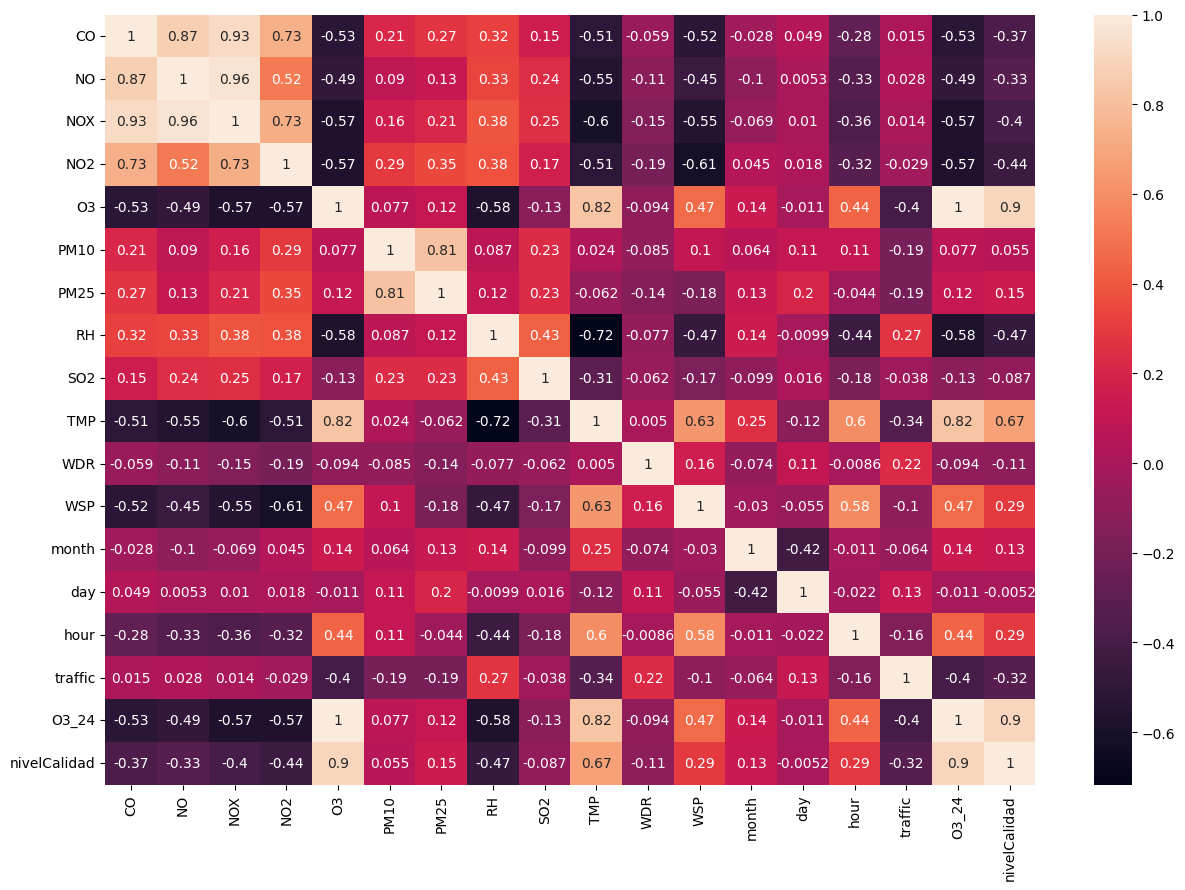

In [19]:
#Matriz de correlación
mer = load_dataset('mer')

mer = mer.drop(columns=['date','idData','year','minutes'])

corr_mer = mer.corr(method="pearson")

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mer, annot=True)
plt.show()


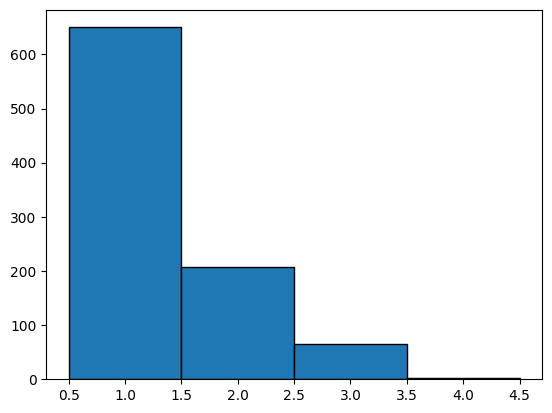

In [20]:
#Conteo de clases
plt.hist(mer['nivelCalidad'], bins=[1, 2, 3, 4, 5], edgecolor='black', align='left')
plt.show()

Datos estadistícos estación UIZ

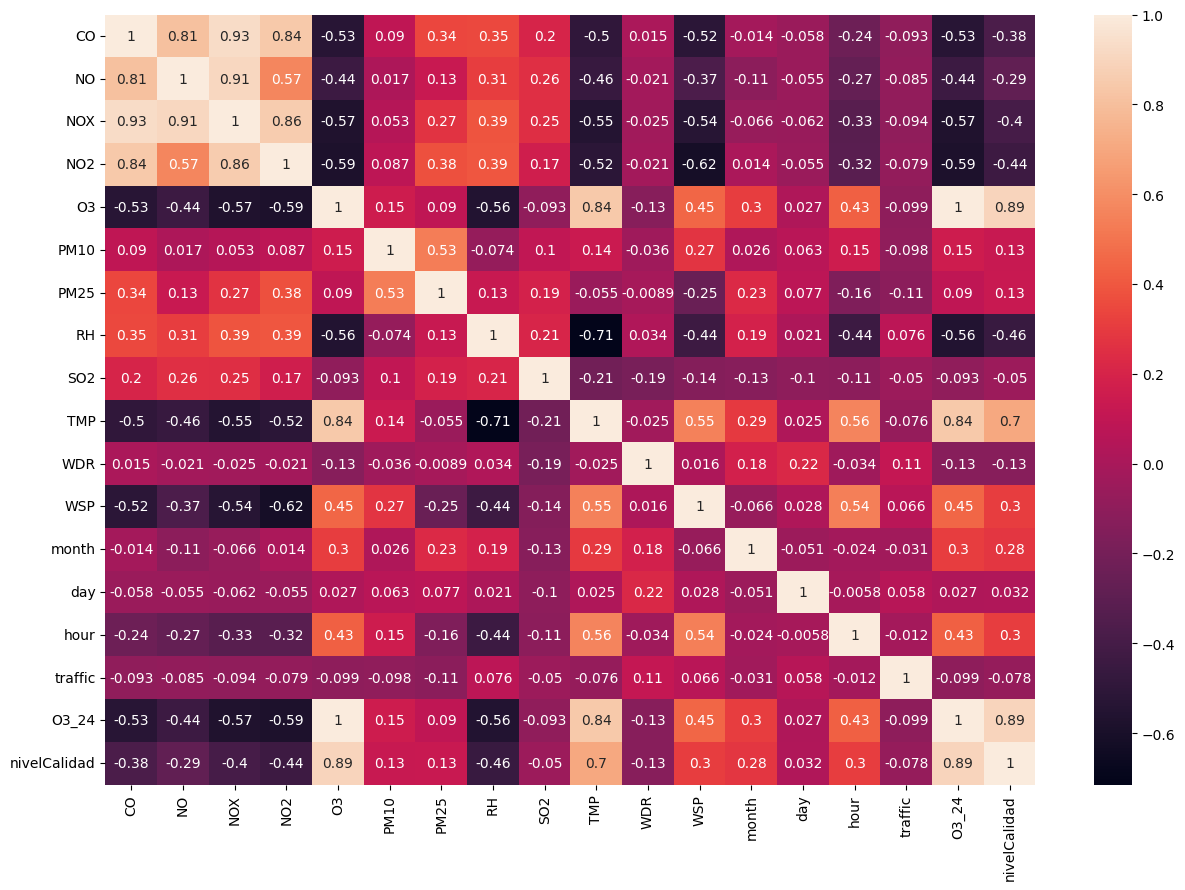

In [22]:
#Matriz de correlación
uiz = load_dataset('uiz')

uiz = uiz.drop(columns=['date','idData','year','minutes'])

corr_uiz = uiz.corr(method="pearson")

plt.figure(figsize=(15, 10))
sns.heatmap(corr_uiz, annot=True)
plt.show()

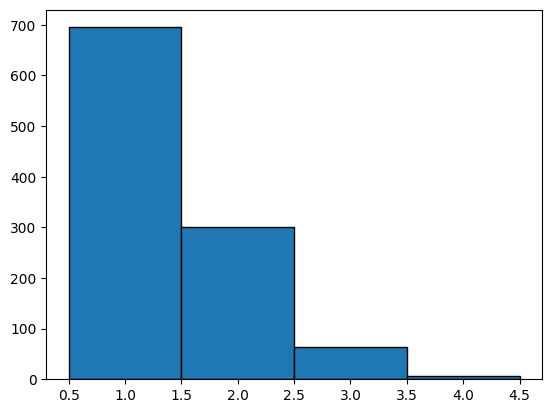

In [23]:
#Conteo de clases
plt.hist(uiz['nivelCalidad'], bins=[1, 2, 3, 4, 5], edgecolor='black', align='left')
plt.show()